<a href="https://colab.research.google.com/github/rickituri98/Fault_Classifier_CNN/blob/master/CNN_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importación de Trabajo de Preprocesamiento y Entrenamiento

In [ ]:
!pip install import_ipynb
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import os
import sys
import numpy as np
import pickle
from scipy.signal import find_peaks
import pywt
import tensorflow as tf
from tensorflow import keras
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
#from comtrade import Comtrade
#from data_handling import import_files
import import_ipynb
import Data_Handling

with open('/content/drive/My Drive/NN/Comtrade_dict.pickle', 'rb') as handle:
    Comtrade_signals = pickle.load(handle)
signals_NOGD = Comtrade_signals.get('NOGD_signals')
signals_GD = Comtrade_signals.get('GD_signals')
print(len(signals_GD), type(signals_NOGD), len(signals_NOGD[0].get("time")))

with open('/content/drive/My Drive/NN/Curves_Lines_NOGD.pickle', 'rb') as handle:
    Curv_Lines_NOGD = pickle.load(handle)
L692_NOGD_c = Curv_Lines_NOGD.get('L692_NOGD')
L632_NOGD_c = Curv_Lines_NOGD.get('L632_NOGD')
L684_NOGD_c = Curv_Lines_NOGD.get('L684_NOGD')
L645_NOGD_c = Curv_Lines_NOGD.get('L645_NOGD')

with open('/content/drive/My Drive/NN/Curves_Lines_GD.pickle', 'rb') as handle:
    Curv_Lines_GD = pickle.load(handle)
L692_GD_c = Curv_Lines_GD.get('L692_GD')
L632_GD_c = Curv_Lines_GD.get('L632_GD')
L684_GD_c = Curv_Lines_GD.get('L684_GD')
L645_GD_c = Curv_Lines_GD.get('L645_GD')
print(len(L692_NOGD_c), len(L692_GD_c))

with open('/content/drive/My Drive/NN/Test_dict.pickle', 'rb') as handle:
    Test_set = pickle.load(handle)
X_test_set = Test_set.get('X_test')
Y_test_set = Test_set.get('Y_test')
print(len(X_test_set), len(Y_test_set))

with open('/content/drive/My Drive/NN/Fault_Categories.pickle', 'rb') as handle:
    Faults_Cat = pickle.load(handle)
ph3_faults_set = Faults_Cat.get('3ph-faults')
ph2_faults_set = Faults_Cat.get('2ph-faults')
ph2g_faults_set = Faults_Cat.get('2phG-faults')
ph1_faults_set = Faults_Cat.get('1ph-faults')
print(len(ph3_faults_set), type(ph3_faults_set))

TrainTest_dict = sio.loadmat('/content/drive/My Drive/NN/Training&Test_set.mat')
X_testset = TrainTest_dict.get("X_test")
Y_testset = TrainTest_dict.get("Y_test")

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=6487538dc9b4e12e0df09ac3fb5ea374435e6f318c7f1a38c41a9a12e5207913
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


ModuleNotFoundError: ignored

# Procesamiento Archivos Comtrade
La estructura de los archivos comtrade corresponde a las lecturas de tensión por fase en unidades físicas (kV)

In [ ]:
path_work = '/content/drive/MyDrive/NN/Oscilografías_Ensayo_Final'
filenames, rec = import_files(path_work)
print(filenames)


ModuleNotFoundError: ignored

ModuleNotFoundError: ignored

Comparativa de eventos con GD y sin GD - Señales de tensión de fase

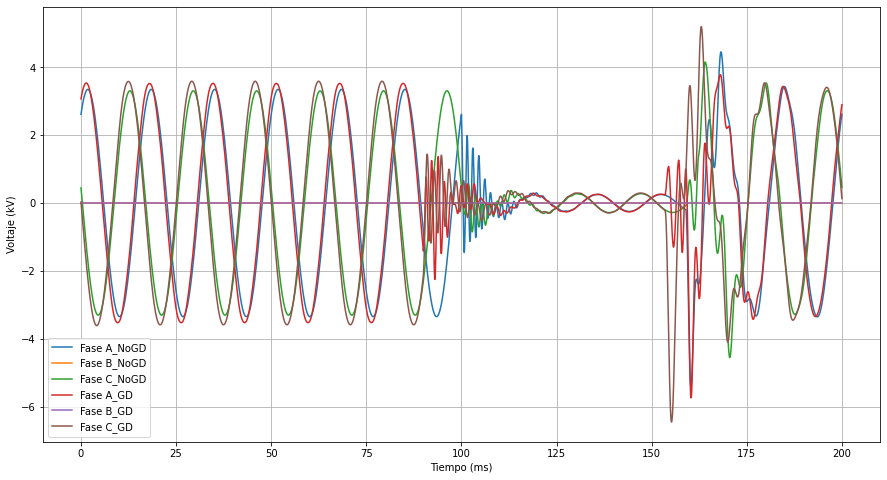

In [ ]:

plt.figure(figsize=(15,8))
plt.plot(1000*signals_NOGD[2].get("time"), signals_NOGD[40].get("A"))
plt.plot(1000*signals_NOGD[2].get("time"), signals_NOGD[40].get("B"))
plt.plot(1000*signals_NOGD[2].get("time"), signals_NOGD[40].get("C"))
plt.plot(1000*signals_GD[2].get("time"), signals_GD[40].get("A"))
plt.plot(1000*signals_GD[2].get("time"), signals_GD[40].get("B"))
plt.plot(1000*signals_GD[2].get("time"), signals_GD[40].get("C"))
plt.legend(["Fase A_NoGD", "Fase B_NoGD", "Fase C_NoGD", "Fase A_GD", "Fase B_GD", "Fase C_GD"])
plt.xlabel("Tiempo (ms)")
plt.ylabel("Voltaje (kV)")
plt.grid()
plt.show()

Curvas de Magnitud vs Distancia (%)

<function matplotlib.pyplot.show>

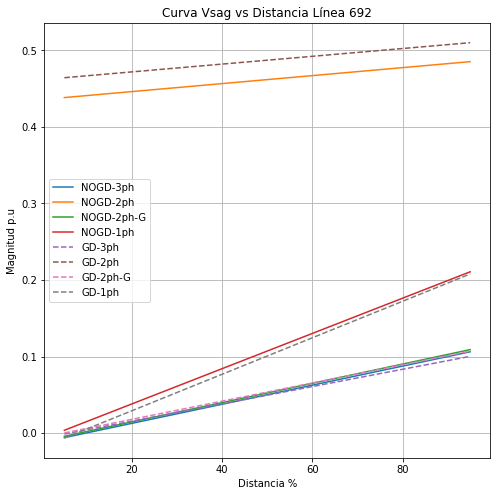

In [ ]:
## Linea 692
plt.figure(figsize=(8,8))
plt.plot(L692_NOGD_c.get('3-ph')[0], L692_NOGD_c.get('3-ph')[1])
plt.plot(L692_NOGD_c.get('2-ph')[0], L692_NOGD_c.get('2-ph')[1])
plt.plot(L692_NOGD_c.get('2-phG')[0], L692_NOGD_c.get('2-phG')[1])
plt.plot(L692_NOGD_c.get('1-ph')[0], L692_NOGD_c.get('1-ph')[1])
plt.plot(L692_GD_c.get('3-ph')[0], L692_GD_c.get('3-ph')[1], '--')
plt.plot(L692_GD_c.get('2-ph')[0], L692_GD_c.get('2-ph')[1], '--')
plt.plot(L692_GD_c.get('2-phG')[0], L692_GD_c.get('2-phG')[1], '--')
plt.plot(L692_GD_c.get('1-ph')[0], L692_GD_c.get('1-ph')[1], '--')
plt.legend(['NOGD-3ph', 'NOGD-2ph', 'NOGD-2ph-G', 'NOGD-1ph', 'GD-3ph', 'GD-2ph', 'GD-2ph-G', 'GD-1ph'])
#plt.legend(['NOGD-3ph', 'GD-3ph'])
#plt.legend(['NOGD-3ph', 'NOGD-2ph', 'NOGD-2ph-G', 'NOGD-1ph'])#, 'GD-3ph', 'GD-2ph', 'GD-2ph-G', 'GD-1ph'])
plt.xlabel("Distancia %")
plt.ylabel("Magnitud p.u")
plt.title("Curva Vsag vs Distancia Línea 692")
plt.grid()
plt.show

<function matplotlib.pyplot.show>

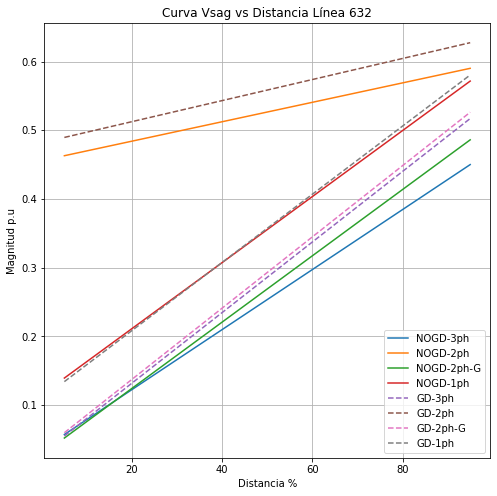

In [ ]:
## Linea 632
plt.figure(figsize=(8,8))
plt.plot(L632_NOGD_c.get('3-ph')[0], L632_NOGD_c.get('3-ph')[1])
plt.plot(L632_NOGD_c.get('2-ph')[0], L632_NOGD_c.get('2-ph')[1])
plt.plot(L632_NOGD_c.get('2-phG')[0], L632_NOGD_c.get('2-phG')[1])
plt.plot(L632_NOGD_c.get('1-ph')[0], L632_NOGD_c.get('1-ph')[1])
plt.plot(L632_GD_c.get('3-ph')[0], L632_GD_c.get('3-ph')[1], '--')
plt.plot(L632_GD_c.get('2-ph')[0], L632_GD_c.get('2-ph')[1], '--')
plt.plot(L632_GD_c.get('2-phG')[0], L632_GD_c.get('2-phG')[1], '--')
plt.plot(L632_GD_c.get('1-ph')[0], L632_GD_c.get('1-ph')[1], '--')
plt.legend(['NOGD-3ph', 'NOGD-2ph', 'NOGD-2ph-G', 'NOGD-1ph', 'GD-3ph', 'GD-2ph', 'GD-2ph-G', 'GD-1ph'])
#plt.legend(['NOGD-3ph', 'GD-3ph'])
#plt.legend(['NOGD-3ph', 'NOGD-2ph', 'NOGD-2ph-G', 'NOGD-1ph'])#, 'GD-3ph', 'GD-2ph', 'GD-2ph-G', 'GD-1ph'])
plt.xlabel("Distancia %")
plt.ylabel("Magnitud p.u")
plt.title("Curva Vsag vs Distancia Línea 632")
plt.grid()
plt.show

<function matplotlib.pyplot.show>

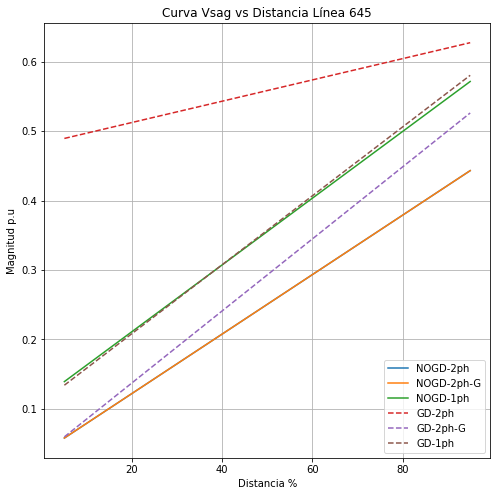

In [ ]:
## Linea 645
plt.figure(figsize=(8,8))
#plt.plot(L632_NOGD_c.get('3-ph')[0], L632_GD_c.get('3-ph')[1])
plt.plot(L645_NOGD_c.get('2-ph')[0], L645_NOGD_c.get('2-ph')[1])
plt.plot(L645_NOGD_c.get('2-phG')[0], L645_NOGD_c.get('2-phG')[1])
plt.plot(L645_NOGD_c.get('1-ph')[0], L645_NOGD_c.get('1-ph')[1])
#plt.plot(L632_GD_c.get('3-ph')[0], L632_GD_c.get('3-ph')[1], '--')
plt.plot(L632_GD_c.get('2-ph')[0], L632_GD_c.get('2-ph')[1], '--')
plt.plot(L632_GD_c.get('2-phG')[0], L632_GD_c.get('2-phG')[1], '--')
plt.plot(L632_GD_c.get('1-ph')[0], L632_GD_c.get('1-ph')[1], '--')
#plt.legend(['NOGD-3ph', 'NOGD-2ph', 'NOGD-2ph-G', 'NOGD-1ph', 'GD-3ph', 'GD-2ph', 'GD-2ph-G', 'GD-1ph'])
#plt.legend(['NOGD-3ph', 'GD-3ph'])
plt.legend(['NOGD-2ph', 'NOGD-2ph-G', 'NOGD-1ph', 'GD-2ph', 'GD-2ph-G', 'GD-1ph'])
plt.xlabel("Distancia %")
plt.ylabel("Magnitud p.u")
plt.title("Curva Vsag vs Distancia Línea 645")
plt.grid()
plt.show

<function matplotlib.pyplot.show>

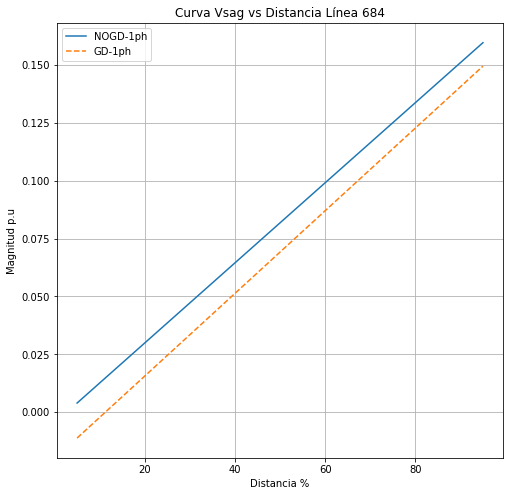

In [ ]:
## Linea 684
plt.figure(figsize=(8,8))
#plt.plot(L632_NOGD_c.get('3-ph')[0], L632_GD_c.get('3-ph')[1])
#plt.plot(L684_NOGD_c.get('2-ph')[0], L645_GD_c.get('2-ph')[1])
#plt.plot(L684_NOGD_c.get('2-phG')[0], L645_GD_c.get('2-phG')[1], 'o')
plt.plot(L684_NOGD_c.get('1-ph')[0], L684_NOGD_c.get('1-ph')[1])
#plt.plot(L632_GD_c.get('3-ph')[0], L632_GD_c.get('3-ph')[1], 'o')
#plt.plot(L632_GD_c.get('2-ph')[0], L632_GD_c.get('2-ph')[1])
#plt.plot(L632_GD_c.get('2-phG')[0], L632_GD_c.get('2-phG')[1])
plt.plot(L684_GD_c.get('1-ph')[0], L684_GD_c.get('1-ph')[1], '--')
#plt.legend(['NOGD-3ph', 'NOGD-2ph', 'NOGD-2ph-G', 'NOGD-1ph', 'GD-3ph', 'GD-2ph', 'GD-2ph-G', 'GD-1ph'])
plt.legend(['NOGD-1ph', 'GD-1ph'])
#plt.legend(['NOGD-2ph', 'NOGD-2ph-G', 'NOGD-1ph'])#, 'GD-3ph', 'GD-2ph', 'GD-2ph-G', 'GD-1ph'])
plt.xlabel("Distancia %")
plt.ylabel("Magnitud p.u")
plt.title("Curva Vsag vs Distancia Línea 684")
plt.grid()
plt.show

Modelo de red Neuronal Funcional

In [ ]:
# Recreatiob of trained Fault classifier model, including its weights and the optimizer
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/NN/Fault_Classifier_model.h5')

# Show the model architecture
trained_model.summary()

# Verification
loss, acc, mse, mae = trained_model.evaluate(X_testset, Y_testset, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "Fault_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2943, 3)]         0         
_________________________________________________________________
conv0 (Conv1D)               (None, 2943, 18)          126       
_________________________________________________________________
pool0 (MaxPooling1D)         (None, 1472, 18)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1472, 36)          1332      
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 736, 36)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 736, 72)           5256      
_________________________________________________________________
pool2 (MaxPooling1D)         (None, 368, 72)      

Operación normal de CNN 

In [ ]:
x_1 = X_testset[-1]
y_1 = Y_testset[-1]
print(x_1.shape,y_1)
np.round(trained_model.predict(X_testset)[-1])

(2943, 3) [1 0 0 0 0]


array([1., 0., 0., 0., 0.], dtype=float32)

Identificación de la caída y fases falladas/ fases con swell

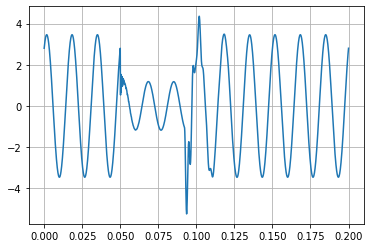

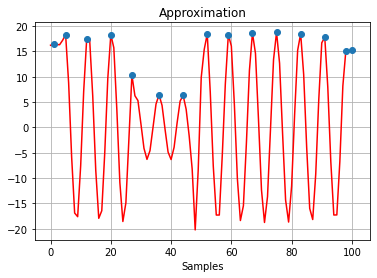

In [ ]:
## Ensayo de detección duración y magnitud de la señal

# prueba con fallas 2ph-g: ph2g_faults_set
testsignala = ph3_faults_set[3].get("A")
testsignalb = ph3_faults_set[3].get("B")
testsignalc = ph3_faults_set[3].get("C")
tsec = ph3_faults_set[0].get("time")


plt.figure()
plt.plot(tsec, testsignala)
plt.grid()
plt.show()
coeffsa = pywt.wavedec(testsignala, 'bior4.4', level=5)
coeffsb = pywt.wavedec(testsignalb, 'bior4.4', level=5)
coeffsc = pywt.wavedec(testsignalc, 'bior4.4', level=5)

cA, cD5, cD4, cD3, cD2, cD1 = coeffsa
#plt.figure()
#plt.plot(cA, color='r')
#plt.xlabel('Samples')
#plt.title('Approx Coeff')
#plt.grid()
#plt.show()
#print(len(testsignal), len(cA))

peaks2, _ = find_peaks(cA, height = 0)

plt.figure()
plt.plot(cA, color='r')
plt.plot(peaks2, cA[peaks2], "o")
plt.xlabel('Samples')
plt.title('Approximation')
plt.grid()
plt.show()




In [ ]:
def time_event(peaks, ind, t_start, t_end, dur, tsec, n):  
  if t_start == 0 and t_end == 0:
    t_start = peaks[ind-1]
    t_end = 1
  else:
    t_end = peaks[ind]
    dur = tsec[-1]*(t_end-t_start)/n
  return t_start, t_end, dur

def sag_detector(cApprox,peaks,Vpre_sag,t_start,t_end,dur,mag, tsec):
  haha=False
  for ind in range(1,len(peaks)-1):
      
      if (cApprox[peaks[ind]]/Vpre_sag) < 0.9: 
        mag = np.min(cApprox[peaks[1:len(peaks)-1]]/Vpre_sag)
        t_start, t_end, dur = time_event(peaks, ind, t_start, t_end, dur, tsec, len(cApprox))
        if haha==False:
          #print('Primero')
          haha=True   
  return dur,mag

def swell_detector(cApprox,peaks,Vpre_swell,t_start,t_end,dur,mag, tsec):
  entro=False
  for ind in range(1,len(peaks)-1):
      
      if (cApprox[peaks[ind]]/Vpre_swell) > 1.1: 
        t_start, t_end, dur = time_event(peaks, ind, t_start, t_end, dur, tsec, len(cApprox))
        mag=np.max(cApprox[peaks[ind]])/Vpre_swell
        if entro==False:
          #print('Segundo')
          entro=True
  return dur,mag

def event_result(cApprox, tsec):

  peaks, _ = find_peaks(cApprox, height = 0)
  
  ph_2 = np.max(cApprox)
  if ph_2 != 0:       
    Vpre_sag = np.max(cApprox[peaks[1:len(peaks)-1]])
    Vpre_swell = np.min(cApprox[peaks[1:len(peaks)-1]])
    #print('sag',Vpre_sag)
    duration1,magnitude1=sag_detector(cApprox,peaks,Vpre_sag,0,0,0,0, tsec)
    #print('swell',Vpre_swell)
    duration2,magnitude2=swell_detector(cApprox,peaks,Vpre_swell,0,0,0,0, tsec)
    #print('mag1',magnitude1,'dur1',duration1)
    #print('mag2',magnitude2,'dur2',duration2)
    if magnitude1<0.9 and duration1<=duration2:
      return duration1,magnitude1,True #Tipo Sag
    return duration2,magnitude2,False #Tipo Swell

  else:
    return 0, 0, False 

print("Fase: /   ","tiempo evento   /", 'magnitud    /', 'Es Sag?')
print("A", event_result(cA, tsec))
print("B", event_result(coeffsb[0], tsec))
print("C", event_result(coeffsc[0], tsec))

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#print("Loc", find_nearest(array, value))


Fase: tiempo evento magnitud Es Sag?
A (0.15294117647058825, 0.3356830479850714, True)
B (0.04509803921568628, 0.2952025028137968, True)
C (0.049019607843137254, 0.3312491713577848, True)
